In [1]:
# Import library

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer, SimpleImputer
from category_encoders import HashingEncoder
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import lightgbm as lgb

# Training data preparation

In [2]:
# Read data

train_data = pd.read_csv('train.csv')

X_train_data = train_data.drop(['Transported'], axis='columns')
Y_train_data = train_data['Transported']

In [3]:
def impute_data(df):

    ## Missing value
    cat_col = ['HomePlanet','CryoSleep', 'Destination', 'VIP']
    num_col = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    # Using Simple Imputer to deal with missing value of categorical variables
    imputer = SimpleImputer(strategy="most_frequent")
    imputer.fit(df[cat_col])
    df[cat_col] = imputer.transform(df[cat_col])

    # Using KNN Imputer to deal with missing value of numerical variables
    imputer = KNNImputer(n_neighbors=int(np.sqrt(len(df.index))))
    imputer.fit(df[num_col])
    df[num_col] = imputer.transform(df[num_col])

    # Remove missing value of cabin and name (because can not fill those missing value)
    # df = df.dropna(axis='index')

    return df

def impute_data2(df):
        
    # For passengers in CryoSleep we impute zero for missing amenities values
    amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df.loc[df.CryoSleep.eq(True), amenities] = 0
    
    ## Missing value
    cat_col = ['HomePlanet','CryoSleep', 'Destination', 'VIP']
    num_col = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    # Using Simple Imputer to deal with missing value of categorical variables
    imputer = SimpleImputer(strategy="most_frequent")
    imputer.fit(df[cat_col])
    df[cat_col] = imputer.transform(df[cat_col])

    # Using KNN Imputer to deal with missing value of numerical variables
    imputer = KNNImputer(n_neighbors=int(np.sqrt(len(df.index))))
    imputer.fit(df[num_col])
    df[num_col] = imputer.transform(df[num_col])

    # Remove missing value of cabin and name (because can not fill those missing value)
    # df = df.dropna(axis='index')

    return df

X_train_data = impute_data2(X_train_data)

In [4]:
def split_column(df):

    # Create a column "PassengerGroup" from "PassengerId" 
    df['PassengerGroup'] = df['PassengerId'].str.split('_').str[0]

    # Create column "LastName" from "Name"
    df['LastName'] = df['Name'].str.split(' ').str[1]

    # Split column "Cabin" into 3 columns "CabinDeck", "CabinNum", "CabinSide"
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df.Cabin.str.split('/', expand = True)

    # Drop 3 columns "PassengerId", "Name" and "Cabin"
    df = df.drop(['PassengerId', 'Name', 'Cabin', 'CabinNum'], axis='columns')

    return df

X_train_data = split_column(X_train_data)

In [5]:
# Convert boolean to integer: 0 = False, 1 = True

def bool_to_int(df):
    df['CryoSleep'] = list(map(int, df['CryoSleep']))
    df['VIP'] = list(map(int, df['VIP']))
    return df

X_train_data = bool_to_int(X_train_data)

Y_train_data = pd.Series(list(map(int, Y_train_data)))

In [6]:
def dummy_variable(df):

    # Create dummy variables and drop original ones

    HomePlanetDummies = pd.get_dummies(df['HomePlanet'], prefix='HomePlanet')
    df = pd.concat([df, HomePlanetDummies], axis='columns')

    DestinationDummies = pd.get_dummies(df['Destination'], prefix='Destination')
    df = pd.concat([df, DestinationDummies], axis='columns')

    CabinDeckDummies = pd.get_dummies(df['CabinDeck'], prefix='CabinDeck')
    df = pd.concat([df, CabinDeckDummies], axis='columns')

    CabinSideDummies = pd.get_dummies(df['CabinSide'], prefix='CabinSide')
    df = pd.concat([df, CabinSideDummies], axis='columns')

    df = df.drop(['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide'], axis='columns')

    return df

X_train_data = dummy_variable(X_train_data)

In [7]:
def hashing_encode(df):

    # Using feature hashing to encode PassengerGroup, CabinDeck and LastName

    encoder = HashingEncoder(cols='PassengerGroup',n_components=10)
    PassengerGroupDummies = pd.DataFrame(encoder.fit_transform(df['PassengerGroup']))
    PassengerGroupDummies = PassengerGroupDummies.add_prefix('PassengerGroup_')
    df = pd.concat([df, PassengerGroupDummies], axis='columns')

    # encoder = HashingEncoder(cols='CabinDeck',n_components=5)
    # CabinDeckDummies = pd.DataFrame(encoder.fit_transform(df['CabinDeck']))
    # CabinDeckDummies = CabinDeckDummies.add_prefix('CabinDeck_')
    # df = pd.concat([df, CabinDeckDummies], axis='columns')

    encoder = HashingEncoder(cols='LastName',n_components=5)
    LastNameDummies = pd.DataFrame(encoder.fit_transform(df['LastName']))
    LastNameDummies = LastNameDummies.add_prefix('LastName_')
    df = pd.concat([df, LastNameDummies], axis='columns')

    # df = df.drop(['PassengerGroup', 'CabinDeck', 'LastName'], axis='columns')
    df = df.drop(['PassengerGroup', 'LastName'], axis='columns')

    return df

X_train_data = hashing_encode(X_train_data)

In [8]:
# Standardization
"""
scaler = StandardScaler().fit(X_train_data)

X_train_data = pd.DataFrame(scaler.transform(X_train_data))

"""

'\nscaler = StandardScaler().fit(X_train_data)\n\nX_train_data = pd.DataFrame(scaler.transform(X_train_data))\n\n'

# Testing data preparation

In [9]:
# Read data

X_test_data = pd.read_csv('test.csv')

# For writing to submission file
PassengerIdTest = X_test_data['PassengerId']

In [10]:
X_test_data = impute_data2(X_test_data)

In [11]:
X_test_data = split_column(X_test_data)

In [12]:
X_test_data = bool_to_int(X_test_data)

In [13]:
X_test_data = dummy_variable(X_test_data)

In [14]:
X_test_data = hashing_encode(X_test_data)

In [15]:
# Standardization

"""
X_test_data = pd.DataFrame(scaler.transform(X_test_data))

"""

'\nX_test_data = pd.DataFrame(scaler.transform(X_test_data))\n\n'

# Training and testing

### Lightgbm

##### AGE experiment

In [44]:
X_train_data["Age"] = pd.cut(x=X_train_data["Age"].astype(float), bins=[0,10,20,60,float('inf')], labels=['chilf','teenager','adult','old'])
encoder = HashingEncoder(cols='Age',n_components=4)
AgeDummies = pd.DataFrame(encoder.fit_transform(X_train_data['Age']))
AgeDummies = AgeDummies.add_prefix('Age_')
X_train_data = pd.concat([X_train_data, AgeDummies], axis='columns')

X_test_data["Age"] = pd.cut(x=X_test_data["Age"].astype(float), bins=[0,10,20,60,float('inf')], labels=['chilf','teenager','adult','old'])
encoder = HashingEncoder(cols='Age',n_components=4)
AgeDummies = pd.DataFrame(encoder.fit_transform(X_test_data['Age']))
AgeDummies = AgeDummies.add_prefix('Age_')
X_test_data = pd.concat([X_test_data, AgeDummies], axis='columns')


In [46]:
X_train_data = X_train_data.drop(['Age'], axis='columns')
X_test_data = X_test_data.drop(['Age'], axis='columns')

In [47]:
lgbm = lgb.LGBMClassifier(boosting_type ='gbdt', learning_rate = 0.005, n_estimators = 500, num_leaves = 31)
lgbm.fit(X_train_data, Y_train_data)

LGBMClassifier(learning_rate=0.005, n_estimators=500)

In [48]:
prediction = lgbm.predict(X_test_data)

In [50]:
res = pd.DataFrame(
{
             'PassengerId': list(PassengerIdTest),
             'Transported': [(p == 1) for p in list(prediction)]
         }
)
res.to_csv('prediction.csv', index=False)

### Variable Selection using RFE (BEST ATTEMPT)

In [105]:
import lightgbm as lgb
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from lightgbm import LGBMClassifier

def select_features_with_rfe(X, y, n_splits=5):
    """
    Performs feature selection on a pandas DataFrame using Recursive Feature Elimination with cross-validation.

    Args:
        X (pandas.DataFrame): DataFrame containing the features.
        y (pandas.Series): Series containing the target variable.
        n_splits (int): Number of folds to use for cross-validation.

    Returns:
        pandas.DataFrame: New DataFrame containing the selected features and target variable.
    """

    # Set up a LightGBM model
    model = LGBMClassifier(objective='binary', metric='accuracy', feature_fraction=0.8, lambda_l1=0.1, lambda_l2=0.1)

    # Set up recursive feature elimination with cross-validation
    rfecv = RFECV(estimator=model, step=1, cv=KFold(n_splits=n_splits, shuffle=True, random_state=42), scoring='accuracy')

    # Fit the recursive feature elimination to the data
    rfecv.fit(X, y)

    # Get the selected features
    selected_features = X.columns[rfecv.support_]

    # Create a new DataFrame with the selected features and target variable
    selected_df = X[selected_features]
    #selected_df['target'] = y

    return selected_df



In [106]:
df=select_features_with_rfe(X_train_data, Y_train_data, n_splits=5)

In [107]:
df.columns

Index(['CryoSleep', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_C',
       'CabinDeck_D', 'CabinDeck_E', 'CabinDeck_F', 'CabinDeck_G',
       'CabinSide_P', 'CabinSide_S', 'PassengerGroup_col_0',
       'PassengerGroup_col_1', 'PassengerGroup_col_2', 'PassengerGroup_col_3',
       'PassengerGroup_col_4', 'PassengerGroup_col_5', 'PassengerGroup_col_6',
       'PassengerGroup_col_8', 'PassengerGroup_col_9', 'LastName_col_0',
       'LastName_col_1', 'LastName_col_3', 'LastName_col_4'],
      dtype='object')

In [116]:
X_test_variable_selection = X_test_data[['CryoSleep', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_C',
       'CabinDeck_D', 'CabinDeck_E', 'CabinDeck_F', 'CabinDeck_G',
       'CabinSide_P', 'CabinSide_S', 'PassengerGroup_col_0',
       'PassengerGroup_col_1', 'PassengerGroup_col_2', 'PassengerGroup_col_3',
       'PassengerGroup_col_4', 'PassengerGroup_col_5', 'PassengerGroup_col_6',
       'PassengerGroup_col_8', 'PassengerGroup_col_9', 'LastName_col_0',
       'LastName_col_1', 'LastName_col_3', 'LastName_col_4']]

In [109]:
#Prediction using selected data

In [113]:
lgbm = lgb.LGBMClassifier(boosting_type ='gbdt', learning_rate = 0.005, n_estimators = 500, num_leaves = 31)
lgbm.fit(df, Y_train_data)

LGBMClassifier(learning_rate=0.005, n_estimators=500)

In [117]:
prediction = lgbm.predict(X_test_variable_selection)

In [118]:
res = pd.DataFrame(
{
             'PassengerId': list(PassengerIdTest),
             'Transported': [(p == 1) for p in list(prediction)]
         }
)
res.to_csv('prediction.csv', index=False)

In [119]:
X_test_data

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,PassengerGroup_col_5,PassengerGroup_col_6,PassengerGroup_col_7,PassengerGroup_col_8,PassengerGroup_col_9,LastName_col_0,LastName_col_1,LastName_col_2,LastName_col_3,LastName_col_4
0,1,27.000000,0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,1,0,0,1,0,0,0
1,0,19.000000,0,0.0,9.0,0.0,2823.0,0.0,1,0,...,0,0,0,1,0,1,0,0,0,0
2,1,31.000000,0,0.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,38.000000,0,0.0,6652.0,0.0,181.0,585.0,0,1,...,0,1,0,0,0,1,0,0,0,0
4,0,20.000000,0,10.0,0.0,635.0,0.0,0.0,1,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1,34.000000,0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,1,0,0,0,0,0,1,0
4273,0,42.000000,0,0.0,847.0,17.0,10.0,144.0,1,0,...,0,0,0,1,0,1,0,0,0,0
4274,1,26.646154,0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1
4275,0,35.169231,0,0.0,2680.0,0.0,0.0,523.0,0,1,...,0,1,0,0,0,1,0,0,0,0


### Variable Selection using RFE

In [258]:
from sklearn.model_selection import cross_val_score

def select_features_with_cv(X, y, n_splits=5):
    """
    Performs feature selection on a pandas DataFrame using chi-squared test with cross-validation.

    Args:
        X (pandas.DataFrame): DataFrame containing the features.
        y (pandas.Series): Series containing the target variable.
        n_splits (int): Number of folds to use for cross-validation.

    Returns:
        pandas.DataFrame: New DataFrame containing the selected features and target variable.
    """

    # Set up a grid search to select the optimal number of features
    param_grid = {'num_features': range(1, len(X.columns))}
    best_num_features = None
    best_score = 0

    for num_features in param_grid['num_features']:
        # Select the top 'num_features' features using chi-squared test
        select_feature = SelectKBest(chi2, k=num_features).fit(X, y)
        # Get the selected features
        selected_features = X.columns[select_feature.get_support()]
        # Use LightGBM with selected features
        dtrain = lgb.Dataset(X[selected_features], label=y)
        model = lgb.LGBMClassifier(objective='binary', metric='accuracy', feature_fraction=0.8, lambda_l1=0.1, lambda_l2=0.1, dtrain, num_boost_round=100, verbose_eval=False)
        # Evaluate model performance with cross-validation
        cv_scores = cross_val_score(model, X[selected_features], y, cv=KFold(n_splits=n_splits, shuffle=True, random_state=42))
        mean_score = np.mean(cv_scores)
        # Update best number of features and corresponding score
        if mean_score > best_score:
            best_num_features = num_features
            best_score = mean_score

    # Select the top 'best_num_features' features using chi-squared test
    select_feature = SelectKBest(chi2, k=best_num_features).fit(X, y)
    # Get the selected features
    selected_features = X.columns[select_feature.get_support()]

    # Create a new DataFrame with the selected features and target variable
    selected_df = pd.concat([X[selected_features], y], axis=1)

    return selected_df


SyntaxError: positional argument follows keyword argument (1597634129.py, line 28)

In [254]:
dtrain = lgb.Dataset(X_train_data, label=Y_train_data)
params = {'objective': 'binary', 'metric': 'binary_logloss', 'feature_fraction': 0.8, 'lambda_l1': 0.1, 'lambda_l2': 0.1}
model = lgb.LGBMClassifier(params, dtrain, num_boost_round=100, verbose_eval=False)
model.fit(X_train_data,Y_train_data)

In [265]:
df=select_features_with_cv(X_train_data, Y_train_data, n_splits=5)

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\en

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 795, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 594, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\basic.py", line 1694, in __init__
    params_str = param_dict_to_str(params)
  File "C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\basic.py", line 140, in param_dict_to_str
    raise TypeError('Unknown type of parameter:%s, got:%s'
TypeError: Unknown type of parameter:boosting_type, got:dict


# Neural Network experiment

In [18]:
!pip install tensorflow

In [88]:
from sklearn.model_selection import train_test_split

"""
This type of normalization is a bad idea

scaler = StandardScaler().fit(X_train_data)
X_test_data = pd.DataFrame(scaler.transform(X_test_data))
X_train_data = pd.DataFrame(scaler.transform(X_train_data))

"""
X_train, X_test, y_train, y_test = train_test_split(X_train_data, Y_train_data, test_size=0.33, random_state=42)

In [91]:
import tensorflow as tf

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(39,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/200
182/182 [==============================] - 3s 7ms/step - loss: 2.7590 - accuracy: 0.7400 - val_loss: 0.9678 - val_accuracy: 0.7644
Epoch 2/200
182/182 [==============================] - 1s 5ms/step - loss: 0.7483 - accuracy: 0.7740 - val_loss: 0.5670 - val_accuracy: 0.7727
Epoch 3/200
182/182 [==============================] - 1s 5ms/step - loss: 0.5836 - accuracy: 0.7776 - val_loss: 0.6391 - val_accuracy: 0.7769
Epoch 4/200
182/182 [==============================] - 1s 5ms/step - loss: 0.6471 - accuracy: 0.7780 - val_loss: 0.6928 - val_accuracy: 0.7808
Epoch 5/200
182/182 [==============================] - 1s 5ms/step - loss: 0.6003 - accuracy: 0.7876 - val_loss: 0.5173 - val_accuracy: 0.7863
Epoch 6/200
182/182 [==============================] - 1s 5ms/step - loss: 0.5502 - accuracy: 0.7904 - val_loss: 0.5183 - val_accuracy: 0.7707
Epoch 7/200
182/182 [==============================] - 1s 5ms/step - loss: 0.4612 - accuracy: 0.8010 - val_loss: 0.4581 - val_accuracy: 0.7811

Epoch 58/200
182/182 [==============================] - 1s 5ms/step - loss: 0.3614 - accuracy: 0.8336 - val_loss: 0.5520 - val_accuracy: 0.7839
Epoch 59/200
182/182 [==============================] - 1s 5ms/step - loss: 0.3618 - accuracy: 0.8350 - val_loss: 0.5375 - val_accuracy: 0.7856
Epoch 60/200
182/182 [==============================] - 1s 5ms/step - loss: 0.3562 - accuracy: 0.8357 - val_loss: 0.5249 - val_accuracy: 0.7818
Epoch 61/200
182/182 [==============================] - 1s 5ms/step - loss: 0.3587 - accuracy: 0.8357 - val_loss: 0.5711 - val_accuracy: 0.7818
Epoch 62/200
182/182 [==============================] - 1s 5ms/step - loss: 0.3585 - accuracy: 0.8352 - val_loss: 0.5411 - val_accuracy: 0.7804
Epoch 63/200
182/182 [==============================] - 1s 5ms/step - loss: 0.3565 - accuracy: 0.8357 - val_loss: 0.5389 - val_accuracy: 0.7745
Epoch 64/200
182/182 [==============================] - 1s 5ms/step - loss: 0.3539 - accuracy: 0.8372 - val_loss: 0.5670 - val_accuracy:

Epoch 115/200
182/182 [==============================] - 1s 5ms/step - loss: 0.3236 - accuracy: 0.8530 - val_loss: 0.7183 - val_accuracy: 0.7738
Epoch 116/200
182/182 [==============================] - 1s 5ms/step - loss: 0.3190 - accuracy: 0.8501 - val_loss: 0.7087 - val_accuracy: 0.7762
Epoch 117/200
182/182 [==============================] - 1s 5ms/step - loss: 0.3222 - accuracy: 0.8525 - val_loss: 0.7472 - val_accuracy: 0.7766
Epoch 118/200
182/182 [==============================] - 1s 6ms/step - loss: 0.3202 - accuracy: 0.8516 - val_loss: 0.6963 - val_accuracy: 0.7741
Epoch 119/200
182/182 [==============================] - 1s 5ms/step - loss: 0.3250 - accuracy: 0.8499 - val_loss: 0.7183 - val_accuracy: 0.7755
Epoch 120/200
182/182 [==============================] - 1s 6ms/step - loss: 0.3185 - accuracy: 0.8546 - val_loss: 0.6982 - val_accuracy: 0.7797
Epoch 121/200
182/182 [==============================] - 1s 7ms/step - loss: 0.3206 - accuracy: 0.8563 - val_loss: 0.7364 - val_ac

In [92]:
Y_train_data

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Length: 8693, dtype: int64

In [93]:
prediction = list(model.predict(X_test_data))
prediction = [round(p[0]) for p in prediction]

134/134 [==============================] - 0s 3ms/step


In [94]:
res = pd.DataFrame(
{
             'PassengerId': list(PassengerIdTest),
             'Transported': [(p == 1) for p in list(prediction)]
         }
)
res.to_csv('prediction.csv', index=False)

In [9]:
pd.read_csv('train.csv')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [10]:
X_train_data

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,PassengerGroup_col_5,PassengerGroup_col_6,PassengerGroup_col_7,PassengerGroup_col_8,PassengerGroup_col_9,LastName_col_0,LastName_col_1,LastName_col_2,LastName_col_3,LastName_col_4
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,1,0,0,0,1,0,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,1,...,0,0,0,0,0,0,1,0,0,0
8689,1,18.0,0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,1,0,0,0,0,0,0,1
8690,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,0,...,0,0,0,0,1,0,0,0,1,0
8691,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [11]:
X_train_data[]

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'CabinDeck_A',
       'CabinDeck_B', 'CabinDeck_C', 'CabinDeck_D', 'CabinDeck_E',
       'CabinDeck_F', 'CabinDeck_G', 'CabinDeck_T', 'CabinSide_P',
       'CabinSide_S', 'PassengerGroup_col_0', 'PassengerGroup_col_1',
       'PassengerGroup_col_2', 'PassengerGroup_col_3', 'PassengerGroup_col_4',
       'PassengerGroup_col_5', 'PassengerGroup_col_6', 'PassengerGroup_col_7',
       'PassengerGroup_col_8', 'PassengerGroup_col_9', 'LastName_col_0',
       'LastName_col_1', 'LastName_col_2', 'LastName_col_3', 'LastName_col_4'],
      dtype='object')

In [61]:
copy=pd.read_csv('train.csv')


In [62]:
copy.HomePlanet.value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

(array([433., 371., 989., 939., 569., 473., 268., 173.,  59.,  14.]),
 array([ 0. ,  7.8, 15.6, 23.4, 31.2, 39. , 46.8, 54.6, 62.4, 70.2, 78. ]),
 <BarContainer object of 10 artists>)

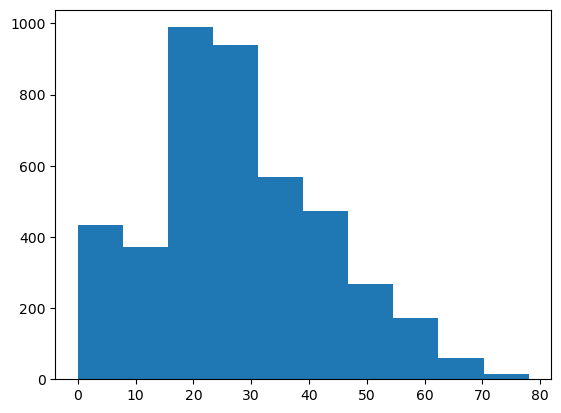

In [69]:
import matplotlib.pyplot as plt
plt.hist(copy[copy['Transported']==True].Age)

(array([ 158.,  278., 1100., 1037.,  719.,  435.,  283.,  143.,   54.,
          19.]),
 array([ 0. ,  7.9, 15.8, 23.7, 31.6, 39.5, 47.4, 55.3, 63.2, 71.1, 79. ]),
 <BarContainer object of 10 artists>)

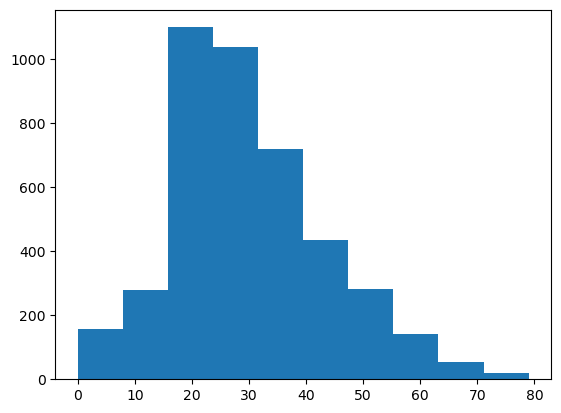

In [70]:
plt.hist(copy[copy['Transported']==False].Age)

In [ ]:
copy